
Import and define Paths to Dataset Directories



In [7]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
#!unzip '/content/drive/MyDrive/bone_data/archive.zip' -d '/content/drive/MyDrive/bone_data/dataset'

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/bone_data/dataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/14-rotated2-rotated2-rotated3 (1).jpg  
  inflating: /content/drive/MyDrive/bone_data/dataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/14-rotated2-rotated2-rotated3-rotated1 (1).jpg  
  inflating: /content/drive/MyDrive/bone_data/dataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/14-rotated2-rotated2-rotated3-rotated1.jpg  
  inflating: /content/drive/MyDrive/bone_data/dataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/14-rotated2-rotated2-rotated3.jpg  
  inflating: /content/drive/MyDrive/bone_data/dataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/14-rotated2-rotated2.jpg  
  inflating: /content/

In [9]:
from pathlib import Path
data_dir = Path('/content/drive/MyDrive/bone_data/dataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification')
train_dir = data_dir / 'train'
test_dir = data_dir / 'test'
val_dir = data_dir / 'val'


Import Libraries

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import warnings
warnings.filterwarnings('ignore')

In [11]:
#Defining parameters
BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180

In [28]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [29]:
#Loading the Datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                              image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              batch_size=BATCH_SIZE)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              batch_size=BATCH_SIZE)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                              image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              batch_size=BATCH_SIZE)

Found 9246 files belonging to 2 classes.
Found 506 files belonging to 2 classes.
Found 829 files belonging to 2 classes.


In [30]:
class_names = train_ds.class_names
class_names

['fractured', 'not fractured']

In [31]:
class_names = train_ds.class_names

def show_images(dataset, title):
    plt.figure(figsize=(6, 6))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i+1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.title(class_names[labels[i]])
            plt.axis('off')
    plt.suptitle(title)
    plt.show()

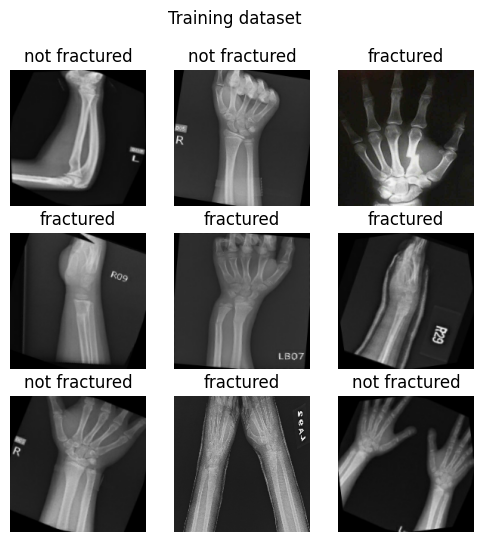

In [32]:
show_images(train_ds, 'Training dataset')

In [33]:
#PLotting class distributions
def count_classes(dataset, class_name):
    return len(list(Path.glob(dataset, f"{class_name}/*")))

def create_class_counts_df(dataset, class_names):
    counts = {'class':[], 'count': []}
    for class_name in class_names:
        counts['class'].append(class_name)
        counts['count'].append(count_classes(dataset, class_name))
    return pd.DataFrame(counts)

def plot_class_distribution(df, title, palette="viridis"):
    sns.barplot(x='class', y='count', data=df, palette=palette)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

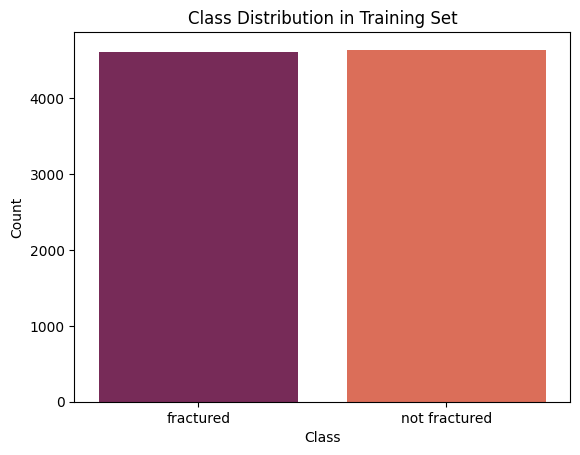

In [34]:
train_df = create_class_counts_df(train_dir, class_names)
plot_class_distribution(train_df, 'Class Distribution in Training Set', palette='rocket')

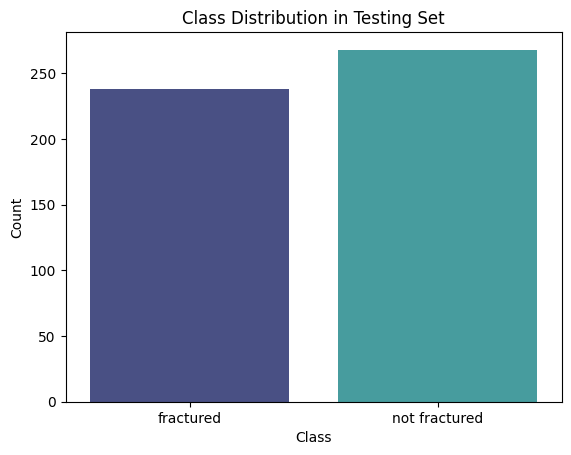

In [35]:
test_df = create_class_counts_df(test_dir, class_names)
plot_class_distribution(test_df, 'Class Distribution in Testing Set', palette='mako')

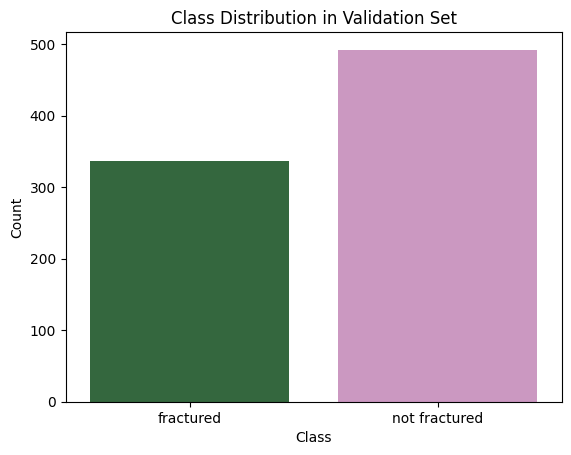

In [36]:
val_df = create_class_counts_df(val_dir, class_names)
plot_class_distribution(val_df, 'Class Distribution in Validation Set', palette='cubehelix')

In [37]:
#Setting up data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [38]:
training_set = train_datagen.flow_from_directory(train_dir,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                batch_size=32,
                                                class_mode='binary')

Found 9246 images belonging to 2 classes.


In [39]:
test_set = train_datagen.flow_from_directory(test_dir,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                batch_size=32,
                                                class_mode='binary')

Found 506 images belonging to 2 classes.


In [40]:
val_set = train_datagen.flow_from_directory(val_dir,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                batch_size=32,
                                                class_mode='binary')

Found 829 images belonging to 2 classes.


In [41]:
#Defining the Model
model = models.Sequential([
    layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,105 (25.36 MB)

 Trainable params: 6,647,105 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
#Compiling the Model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [43]:
#Training the Model
history = model.fit(training_set,
                   validation_data=test_set,
                   epochs=10
                   )

Epoch 1/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 132s 447ms/step - accuracy: 0.6440 - loss: 0.6254 - val_accuracy: 0.7826 - val_loss: 0.5490
Epoch 2/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 121s 419ms/step - accuracy: 0.8701 - loss: 0.3189 - val_accuracy: 0.8458 - val_loss: 0.4297
Epoch 3/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 120s 417ms/step - accuracy: 0.9287 - loss: 0.1854 - val_accuracy: 0.9170 - val_loss: 0.2926
Epoch 4/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 120s 416ms/step - accuracy: 0.9570 - loss: 0.1261 - val_accuracy: 0.8874 - val_loss: 0.2985
Epoch 5/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 119s 412ms/step - accuracy: 0.9645 - loss: 0.0990 - val_accuracy: 0.9209 - val_loss: 0.2287
Epoch 6/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 140s 406ms/step - accuracy: 0.9725 - loss: 0.0773 - val_accuracy: 0.9308 - val_loss: 0.2333
Epoch 7/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 120s 414ms/step - accuracy: 0.9800 - loss: 0.0601 - val_accuracy: 0.9427 - val_loss: 0.2537
Epoch 8/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 119s 413ms/step - accuracy: 0.9788 -

In [44]:
#Evaluating the model
test_loss, test_acc = model.evaluate(test_set)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 681ms/step - accuracy: 0.9756 - loss: 0.0866
Test Accuracy: 0.97
Test Loss: 0.08


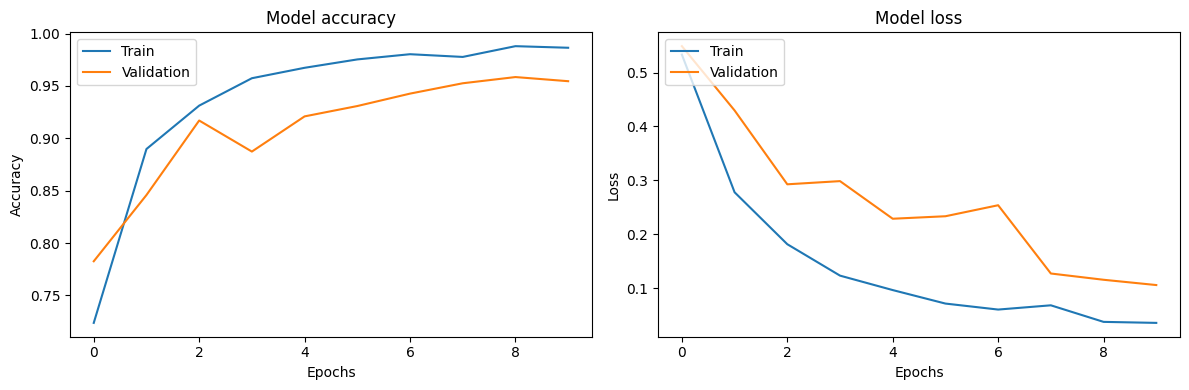

In [45]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [49]:
model.save('/content/drive/MyDrive/bone_data/models/fracture_classification_model.keras')

In [59]:
!pip install protobuf>=5.29.1 --quiet

In [54]:
!pip install -q tf2onnx

In [56]:
import tensorflow as tf
import tf2onnx

model_input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name="input")
model_output = model(model_input)
functional_model = tf.keras.Model(inputs=model_input, outputs=model_output)


spec = (tf.TensorSpec((None, IMG_HEIGHT, IMG_WIDTH, 3), tf.float32, name="input"),)


onnx_model, _ = tf2onnx.convert.from_keras(functional_model, input_signature=spec)


with open("/content/drive/MyDrive/bone_data/models/fracture_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())


ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7ef7c204fba0>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


In [60]:
!pip install numpy --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 90.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.


In [63]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/bone_data/models/fracture_classification_model.keras')

In [64]:
def load_preprocessed_image(image_path, img_height=180, img_width=180):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((img_height, img_width))
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

image_path = '/content/drive/MyDrive/bone_data/dataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/2.png'
preprocessed_img = load_preprocessed_image(image_path)

In [65]:
predictions = loaded_model.predict(preprocessed_img)
predicted_class = np.argmax(predictions, axis=1)
class_names = ['fractured', 'not fractured']

predicted_class = (predictions > 0.5).astype("int32")

print(f"Predicted class: {class_names[predicted_class[0][0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: not fractured


In [66]:
!pip install onnxruntime --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 118.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.8 MB/s eta 0:00:00


In [67]:
import onnxruntime as ort
import numpy as np
from PIL import Image

def load_preprocessed_image(image_path, img_height=180, img_width=180):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((img_height, img_width))
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array.astype(np.float32)


onnx_model_path = '/content/drive/MyDrive/bone_data/models/fracture_model.onnx'
onnx_session = ort.InferenceSession(onnx_model_path)


image_path = '/content/drive/MyDrive/bone_data/dataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/2.png'
preprocessed_img = load_preprocessed_image(image_path)


input_name = onnx_session.get_inputs()[0].name


predictions = onnx_session.run(None, {input_name: preprocessed_img})
predicted_class = (predictions[0] > 0.5).astype("int32")


class_names = ['fractured', 'not fractured']

print(f"Predicted class: {class_names[predicted_class[0][0]]}")


Predicted class: not fractured
